<a href="https://colab.research.google.com/github/elisecolin/Tutorials_Remote_Sensing_notebooks/blob/main/Sentinel_2_Cube.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

This notebook provides a hands-on introduction to image coregistration using Sentinel-2 optical data. Coregistration is the process of aligning a stack of satellite images so that each pixel corresponds to the same geographic location across time.

Although Sentinel-2 Level 2A products are orthorectified and projected onto a common spatial grid, residual misalignments often remain—especially at subpixel level—due to orbital variations, terrain-induced distortions, or sensor inaccuracies. These inconsistencies can hinder pixel-wise analyses such as change detection, time series profiling, or vegetation monitoring.

In this tutorial, we will:

- Retrieve a small spatiotemporal cube of Sentinel-2 imagery using Google Earth Engine (GEE);

- Visualize temporal misalignments using complementary color compositions;

- Estimate and correct subpixel translations using phase correlation in the Fourier domain;

- Optionally, apply corrections using custom or library-based resampling functions.

This notebook is part of a larger series on remote sensing processing techniques and aims to build foundational understanding of Earth Observation workflows. It assumes basic familiarity with Python and NumPy, but no prior knowledge of remote sensing is required.

# Setup and Dependencies

Before we begin, we need to install and import several libraries required for accessing and processing remote sensing data:

- geemap and earthengine-api provide access to Google Earth Engine, enabling us to search and retrieve Sentinel-2 imagery.

- opencv-python is used for image manipulation and visualization.

- matplotlib helps with image display and plotting.

- numpy and scipy.fft are used for numerical operations and Fourier-based image processing.

We also authenticate and initialize Earth Engine with a project ID to enable access to its cloud-based processing platform.

⚠️ Make sure you have authorized access to Google Earth Engine with a valid account before running the code.





In [ ]:
!pip install -q geemap earthengine-api opencv-python matplotlib

import ee
import geemap
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.fft import fft2, ifft2, fftshift



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.7 MB/s eta 0:00:00


## Earth Engine Initialization

To use Earth Engine in Python, we must initialize the API with a valid project ID.
The line below uses the project 'ee-myproject', which corresponds to a specific Earth Engine cloud project.
If you're running this notebook from your own account or organization, replace it with your own project ID (visible in your Google Cloud Console).

In [ ]:
# Initialize Earth Engine
ee.Authenticate()
ee.Initialize(project='ee-myproject')  # Replace with your own Earth Engine project ID if needed


### Image Collection Setup and Preprocessing

In this section, we define the **Area of Interest (AOI)** and the **time range** for retrieving Sentinel-2 imagery using Google Earth Engine (GEE).

- The **AOI** is a small rectangle over central Paris.
- The **time range** spans from June 2022 to June 2024.
- Only images with less than 3% cloud coverage (`CLOUDY_PIXEL_PERCENTAGE < 3`) are retained.
- We focus on **Band 4** (red channel) and convert raw digital numbers to surface reflectance by multiplying by `0.0001`.

The `preprocess()` function applies this filtering and scaling to each image in the collection.

After constructing the image collection, the `get_thumb()` function allows us to download thumbnail images (in PNG format) for local visualization and processing. This function:
- Generates a 256×256 pixel preview using the Earth Engine `getThumbURL` method.
- Downloads and decodes the image into a NumPy array using OpenCV.

This approach provides a quick and lightweight way to extract and manipulate Sentinel-2 data for local analysis.


In [ ]:
# Define AOI and time range
aoi = ee.Geometry.Rectangle([2.2845, 48.85, 2.3155, 48.87])
dates = ('2022-06-01', '2024-06-30')

# Preprocess: scale reflectance and select band 4 (red)
def preprocess(image):
    return image.select('B4').multiply(0.0001).copyProperties(image, ["system:time_start"])

# Load updated Sentinel-2 collection
collection = (ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
              .filterBounds(aoi)
              .filterDate(*dates)
              .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 3))
              .map(preprocess))

from urllib.request import urlopen

def get_thumb(img, vis_params):
    url = img.getThumbURL({
        'region': aoi,
        'dimensions': 256,
        'format': 'png',
        'min': vis_params['min'],
        'max': vis_params['max']
    })
    print("Downloading from:", url)

    # Lire l'image depuis l'URL dans un tableau numpy
    resp = urlopen(url)
    arr = np.asarray(bytearray(resp.read()), dtype=np.uint8)
    img = cv2.imdecode(arr, cv2.IMREAD_GRAYSCALE)
    return img




In [ ]:
# Get the number of images in the filtered Sentinel-2 collection
N = collection.size().getInfo()
print(f"Number of images in collection: {N}")

# Convert the ImageCollection to a list of individual images (server-side to client-side)
images = collection.toList(N)

# Clip each image to the area of interest (AOI) and store them in a list
# This allows us to access and process individual images locally
image_list = [ee.Image(images.get(i)).clip(aoi) for i in range(N)]


Number of images in collection: 18


In [ ]:
def get_thumb_array(image, vis_params):
    # Generate a thumbnail URL for the Earth Engine image using specified visualization parameters
    url = image.getThumbURL({
        'region': aoi,            # Define the region (AOI) to clip the thumbnail to
        'dimensions': 256,        # Set the output image dimensions (in pixels)
        'format': 'png',          # Specify output image format
        'min': vis_params['min'], # Minimum display value for scaling
        'max': vis_params['max']  # Maximum display value for scaling
    })

    # Download the thumbnail image from the generated URL
    resp = urlopen(url)

    # Convert the downloaded binary data into a NumPy array of bytes
    arr = np.asarray(bytearray(resp.read()), dtype=np.uint8)

    # Decode the byte array into a grayscale image using OpenCV
    img = cv2.imdecode(arr, cv2.IMREAD_GRAYSCALE)

    # Return the resulting image as a NumPy array
    return img


In [ ]:
# Download all images and Compute the data cube
# Set visualization parameters to scale reflectance values for display
vis = {'min': 0.0, 'max': 0.3}
# Initialize an empty list to store image arrays
cube = []
# Loop through the list of images
for i, img in enumerate(image_list):
    print(f"Downloading image {i+1}/{N}")  # Progress message
    arr = get_thumb_array(img, vis)       # Download and convert image to numpy array
    cube.append(arr)                      # Append the image to the cube list
# Stack the list of 2D arrays into a 3D numpy array with shape (time, height, width)
cube = np.stack(cube)
# Print the shape of the resulting data cube
print("Cube shape:", cube.shape)


Cube shape: (18, 251, 256)


### Visualizing Misalignment with Complementary Color Composition

This function creates an RGB composite to visually inspect misalignments between two images. The first image is mapped to red, and the second to cyan (green + blue). When the two images are well aligned, the result appears gray or white. Color fringes (red or cyan) highlight areas of discrepancy.


In [ ]:

def compose_complementary(I1, I2):
    """
    Create a false-color RGB composite using two grayscale images.

    Parameters:
    - I1: First grayscale image (2D numpy array), will be mapped to the red channel.
    - I2: Second grayscale image (2D numpy array), will be mapped to both green and blue channels (i.e., cyan).

    Returns:
    - An RGB image (uint8) where differences between I1 and I2 appear as color fringes.
      - White/gray indicates good alignment (I1 ≈ I2)
      - Red highlights content in I1 not present in I2
      - Cyan highlights content in I2 not present in I1
    """
    # Initialize an empty RGB image
    rgb = np.zeros((I1.shape[0], I1.shape[1], 3), dtype=np.uint8)

    # Assign I1 to red channel
    rgb[..., 0] = I1

    # Assign I2 to green and blue channels to form cyan
    rgb[..., 1] = I2
    rgb[..., 2] = I2

    return rgb


### Subpixel Image Translation Using the Fourier Shift Theorem

This function translates a grayscale image by a fractional number of pixels without interpolation in the spatial domain. It uses the Fourier shift theorem, which enables subpixel translation by applying a complex phase ramp in the frequency domain. This method is especially useful when preserving signal integrity is critical, such as in remote sensing or scientific imaging.


In [ ]:
# Apply subpixel translation to an image using Fourier shift theorem
def apply_translation(I, shift):
    """
    Applies a subpixel translation to a 2D image using the Fourier shift theorem.

    Parameters:
    - I: 2D numpy array (grayscale image), assumed to be float or uint8.
    - shift: tuple of two floats (delta_y, delta_x), representing the translation in pixels
             along the vertical (rows) and horizontal (columns) directions.

    Returns:
    - The translated image (real-valued), clipped to [0, 255] for display purposes.

    Notes:
    - This method avoids spatial interpolation artifacts and preserves high-frequency content.
    - The Fourier shift theorem states that translating an image in the spatial domain
      corresponds to multiplying its Fourier transform by a phase ramp in the frequency domain.
    """
    # Get image dimensions
    ny, nx = I.shape

    # Create frequency grids for y (rows) and x (columns)
    Y, X = np.meshgrid(np.fft.fftfreq(ny), np.fft.fftfreq(nx), indexing='ij')

    # Extract subpixel shifts
    delta_y, delta_x = shift

    # Compute the complex phase ramp corresponding to the desired translation
    phase_ramp = np.exp(-2j * np.pi * (delta_x * X + delta_y * Y))

    # Apply the phase shift in the Fourier domain
    I_fft = fft2(I)
    shifted = np.abs(ifft2(I_fft * phase_ramp))

    # Clip to [0, 255] for visualization and return
    return np.clip(shifted, 0, 255)



### Estimate Translations Across a Sentinel-2 Time Series

We now compute the translation between each image in the time series and the first image (used as a reference). We use `phase_cross_correlation` from `skimage.registration`, which estimates subpixel translations in the Fourier domain. This method is robust to uniform illumination changes and works well even in low-texture regions. The `upsample_factor=100` ensures high-precision alignment, detecting shifts with subpixel accuracy.


In [ ]:
# Compute pairwise translations between the reference image and the rest of the stack
from skimage.registration import phase_cross_correlation
from scipy.ndimage import fourier_shift

# Reference image: first image in the cube
I1 = cube[0]

# Loop through all images in the stack
for k in range(N):
    I2 = cube[k]  # Current image to align with the reference

    # Estimate the translation that best aligns I2 to I1
    # phase_cross_correlation returns (shift_y, shift_x)
    # upsample_factor=100 improves subpixel accuracy
    shift, error, _ = phase_cross_correlation(I1, I2, upsample_factor=100)

    # Print the estimated shift in pixels
    print(f"Image {k} - Estimated shift relative to image 0: {shift}")


Image 0 - Estimated shift relative to image 0: [0. 0.]
Image 1 - Estimated shift relative to image 0: [-0.04  0.01]
Image 2 - Estimated shift relative to image 0: [-0.07  0.01]
Image 3 - Estimated shift relative to image 0: [0.02 0.01]
Image 4 - Estimated shift relative to image 0: [-0.79 -0.12]
Image 5 - Estimated shift relative to image 0: [-0.02 -0.01]
Image 6 - Estimated shift relative to image 0: [-0.03 -0.03]
Image 7 - Estimated shift relative to image 0: [-0.09 -0.03]
Image 8 - Estimated shift relative to image 0: [-0.13 -0.07]
Image 9 - Estimated shift relative to image 0: [0.06 0.02]
Image 10 - Estimated shift relative to image 0: [ 0.11 -0.05]
Image 11 - Estimated shift relative to image 0: [-0.1  -0.01]
Image 12 - Estimated shift relative to image 0: [ 0.04 -0.05]
Image 13 - Estimated shift relative to image 0: [0.04 0.06]
Image 14 - Estimated shift relative to image 0: [0.02 0.02]
Image 15 - Estimated shift relative to image 0: [-0.03 -0.07]
Image 16 - Estimated shift relat

### Visualize Registration Before and After Correction

To illustrate the effect of registration, we align one of the most misaligned images (`I2`) in the time series to the reference image (`I1`).  
We estimate the subpixel shift using phase correlation and apply the translation in the Fourier domain.  
Two red/cyan composites are shown to visualize the spatial alignment before and after correction. Perfect registration should appear gray; misalignments produce color fringes.


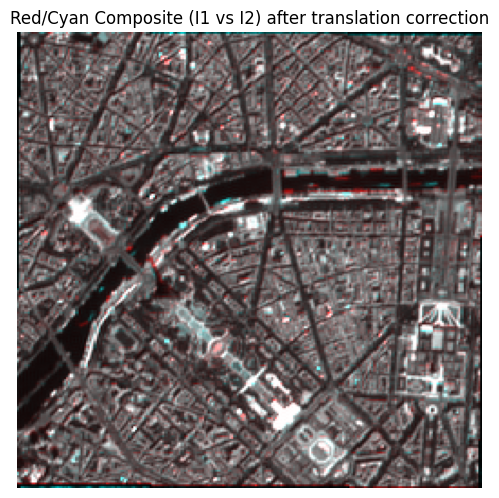

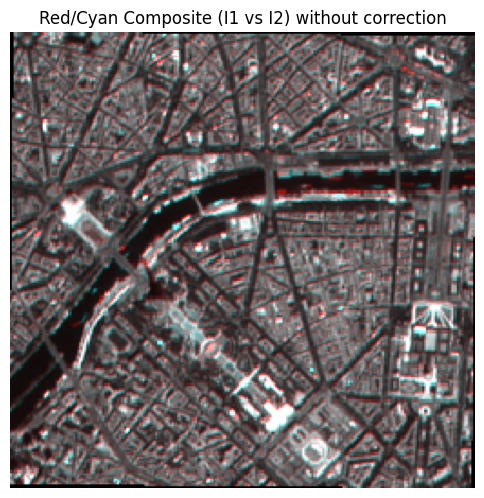

In [ ]:
# Apply correction for the image with the largest misregistration (example: image 4)

# Select two images from the cube: the reference (I1) and a misaligned image (I2)
I1 = cube[0]       # Reference image (first in the stack)
I2 = cube[4]       # A later image, assumed to be more misaligned

# Estimate the translation between the two images using phase correlation
# This computes the pixel shift needed to align I2 to I1
shift, error, _ = phase_cross_correlation(I1, I2, upsample_factor=20)

# Apply the computed subpixel shift to I2 to align it with I1
I2_aligned = apply_translation(I2, shift)

# Display a red/cyan composite after alignment
# Correctly registered areas should appear gray/white, while misalignments show color fringes
rgb_comp = compose_complementary(I1, I2_aligned)
plt.figure(figsize=(6, 6))
plt.imshow(rgb_comp)
plt.title('Red/Cyan Composite (I1 vs I2) after translation correction')
plt.axis('off')
plt.show()

# Display the same composite without alignment, for comparison
rgb_comp = compose_complementary(I1, I2)
plt.figure(figsize=(6, 6))
plt.imshow(rgb_comp)
plt.title('Red/Cyan Composite (I1 vs I2) without correction')
plt.axis('off')
plt.show()
